In [13]:
import os
SLURM_PATH = '/home/yandex/MLWG2025/amitr5'
CACHE_DIR = f'{SLURM_PATH}/tmp/hf_cache' 

if SLURM_PATH in os.getcwd():
        os.makedirs(CACHE_DIR, exist_ok=True)
        os.environ["PIP_PATH"] = f"{SLURM_PATH}/BaryGNN/anaconda3/envs/conf/bin/pip"
        os.environ["TEMP_DIR"] = CACHE_DIR
        os.environ["HF_HOME"] = CACHE_DIR
        os.environ["TRANSFORMERS_CACHE"] = CACHE_DIR
        os.environ["HF_DATASETS_CACHE"] = CACHE_DIR
        # Hugging Face uses HUGGINGFACE_HUB_CACHE (HF_HUB_CACHE is ignored)
        os.environ["HUGGINGFACE_HUB_CACHE"] = CACHE_DIR
        os.environ["TMPDIR"] = CACHE_DIR
        os.environ["XDG_CACHE_HOME"] = CACHE_DIR
        # os.environ["TOKENIZERS_PARALLELISM"] = "false"


os.environ["CUDA_VISIBLE_DEVICES"] = "0,2,3"

In [15]:
# Imports #
import numpy as np
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import os
import pandas as pd
# from datasets import load_dataset
# import torch.nn.functional as F

# Project imports #

import utils
from mind2web.dataloader import build_split_datasets
from utils import CACHE_DIR
from utils import log_response
# sys.path.append('./Mind2Web/src')

In [17]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", cache_dir=CACHE_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"

# model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=CACHE_DIR, device_map="auto")
# model.eval();

In [18]:
# utils.reload('mind2web.dataloader')
idx_split_map = {0:"test_task", 1:"test_domain", 2:"test_website"}
split_idx_map = {v:k for k,v in idx_split_map.items()}

cal_dict, test_dict = build_split_datasets(idx_split_map.values(),
                                            tokenizer,
                                              seed=42,
                                              frac=0.1,
                                              cache_dir=CACHE_DIR)


Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

In [19]:
# cal_df = utils.llm.run_evaluation(cal_dict, model, tokenizer)
# cal_df.to_pickle("cal_results.pkl")
cal_df = pd.read_pickle("cal_results.pkl")
cal_df.head()

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens
0,0,e8b1cc02-1143-47cf-a7bb-9a16d08e155a,d8f56437-243c-41e3-a77c-8d19b22fd1c8,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.002743479795753956, 'B': 0.99698418378...",0.996984,0,B.\nAction: CLICK\n
1,1,e8b1cc02-1143-47cf-a7bb-9a16d08e155a,65f582dc-9578-46f7-a5c7-90bcf9271a44,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0009796916274353862, 'B': 0.9989228844...",0.998923,0,B.\nAction: CLICK\n
2,2,e8b1cc02-1143-47cf-a7bb-9a16d08e155a,928b03e6-79d6-4f20-94c5-61fb759a7d7a,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.2513953149318695, 'B': 0.6566342711448...",0.656634,0,B.\nAction: CLICK\n
3,3,b59b1997-884f-42f0-b083-fc93d6ce64fe,436775bf-ab7f-42f6-929f-b22e8101c495,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.03369608893990517, 'B': 0.965908348560...",0.965908,0,B.\nAction: CLICK\n
4,4,b59b1997-884f-42f0-b083-fc93d6ce64fe,241b5853-ce15-42eb-8fb3-66e51c328f3b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0006505440687760711, 'B': 0.9992752671...",0.999275,0,B.\nAction: CLICK\n


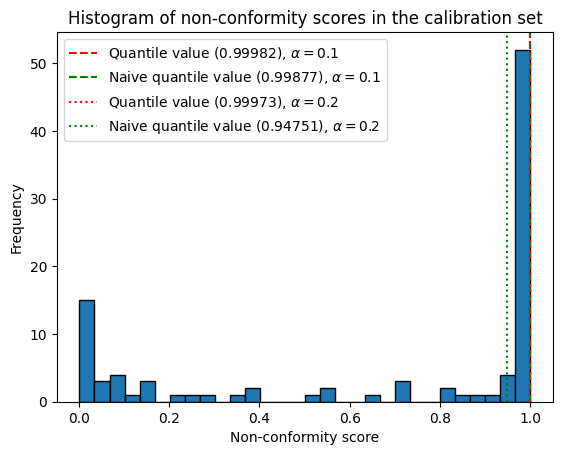

A good predictor should have low non-conformity scores, concentrated at the left side of the figure


In [20]:
def get_threshold(scores, alpha: float):
    N = len(scores)
    k = int(np.ceil((N + 1) * (1 - alpha)))
    sorted_scores = np.sort(scores.values)
    threshold = sorted_scores[k - 1]
    return threshold


cal_df['correct'] = cal_df['pred_label'] == cal_df['label']
# probability of the true label
cal_df['true_prob'] = cal_df.apply(lambda row: row['choices_probs'][row['label']] if row['label'] in row['choices_probs'] else 0, axis=1)

# google's nonconformity score
grouped = cal_df.groupby('annotation_id')
score_per_group = 1 - grouped['true_prob'].min()

threshold = get_threshold(score_per_group, alpha=0.1)

naive_threshold = get_threshold(1 - cal_df['true_prob'], alpha=0.1)
naive_threshold2 = get_threshold(1 - cal_df['true_prob'], alpha=0.2)
threshold2 = get_threshold(score_per_group, alpha=0.2)

# plot histogram of non-conformity scores in the calibration set
utils.plot.nonconformity_histogram(
    score_per_group, threshold, naive_threshold, threshold2, naive_threshold2
)

pred_label
A    162
D      5
B      2
F      1
E      1
Name: count, dtype: int64


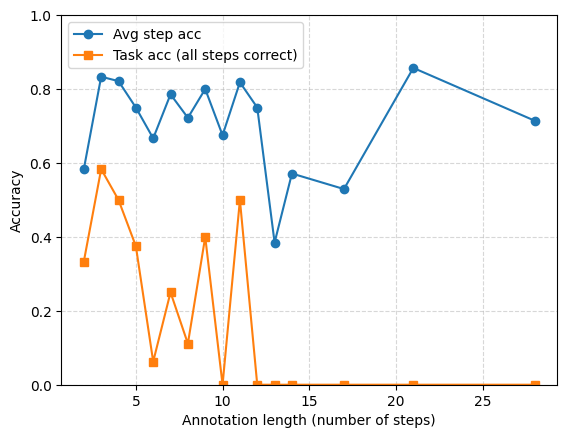

In [35]:
# Model is probably biased towards A when not certain
print(cal_df[cal_df['correct'] == False]['pred_label'].value_counts())
utils.plot.accuracy_vs_length(cal_df);

In [21]:
# test_df = run_evaluation(test_dict)
# test_df.to_pickle("test_results.pkl")
test_df = pd.read_pickle("test_results.pkl")
test_df.head()


,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens
0,0,91695df8-f256-47c9-8c37-06e8d0fc758f,73e0e7ed-d784-4b7a-a06c-48324e44ce7b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.15193545818328857, 'B': 0.846724271774...",0.846724,0,B.\nAction: CLICK\n
1,1,91695df8-f256-47c9-8c37-06e8d0fc758f,ea2865e4-2858-478c-bf83-93d576cad774,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0009128428064286709, 'B': 0.9990413784...",0.999041,0,B.\nAction: CLICK\n
2,2,91695df8-f256-47c9-8c37-06e8d0fc758f,c70a5d9b-8777-4ff7-a17d-1f76012e14ba,B,TYPE,08817,B,B.\nAction: TYPE\nValue: 08817,"{'A': 0.002360111102461815, 'B': 0.99749302864...",0.997493,0,B.\nAction: TYPE\nValue: 08817
3,3,91695df8-f256-47c9-8c37-06e8d0fc758f,3e671043-cab2-4e44-a1ce-3ed9de91d16b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0015765962889418006, 'B': 0.9983214735...",0.998321,0,B.\nAction: CLICK\n
4,4,91695df8-f256-47c9-8c37-06e8d0fc758f,60888ab2-b605-4886-8dac-6ba72b6cde0a,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.010480514727532864, 'B': 0.98891687393...",0.988917,0,B.\nAction: CLICK\n


In [22]:
test_df['correct'] = test_df['pred_label'] == test_df['label']
test_df['pred_set'] = test_df['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= threshold])
test_df['pred_set_size'] = test_df['pred_set'].apply(len)
test_task_group = test_df.groupby('annotation_id')

print(test_df["correct"].mean())
print(test_df['pred_set_size'].mean())
print((test_df['pred_set_size'] > 1).mean())

0.7263321262286602
3.42058975685463
0.9736161407139162


In [21]:
import numpy as np
import pandas as pd

def _token_f1(pred: str, label: str) -> float:
    p = set(pred.strip().split())
    l = set(label.strip().split())
    if not p and not l:
        return 1.0
    if not p or not l:
        return 0.0
    tp = len(p & l)
    fp = len(p - l)
    fn = len(l - p)
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec = tp / (tp + fn) if (tp + fn) else 0.0
    return 0.0 if (prec == 0 or rec == 0) else 2 * prec * rec / (prec + rec)

def evaluate_results_df(results_df: pd.DataFrame) -> dict:
    # Element accuracy: mean of the “correct” flag (generated == label)
    element_acc = results_df["correct"].mean()

    # Operation F1: token-level F1 between generated and label_text
    op_f1 = np.mean([
        _token_f1(str(g), str(l))
        for g, l in zip(results_df["pred_label"], results_df["label_text"])
    ])

    # Step SR (macro across tasks): average of mean correctness per annotation_id
    per_ann_correct = results_df.groupby("annotation_id")["correct"].mean()
    step_sr = per_ann_correct.mean()

    # Task SR (all steps correct within an annotation_id)
    task_sr = (results_df.groupby("annotation_id")["correct"].all()).mean()

    return {
        "element_acc": round(element_acc,2),
        "op_f1": round(op_f1,2),
        "step_sr": round(step_sr,2),
        "task_sr": round(task_sr,2),
    }

print("Evaluation on Cal Set")
print("Overall Metrics:")
print(evaluate_results_df(cal_df))

for idx_split, split_name in idx_split_map.items():
    print(f"Metrics for split: {split_name}")
    split_df = cal_df[cal_df["test_split"] == idx_split]
    print(evaluate_results_df(split_df))


Evaluation on Cal Set
Overall Metrics:
{'element_acc': np.float64(0.72), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.75), 'task_sr': np.float64(0.32)}
Metrics for split: test_task
{'element_acc': np.float64(0.86), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.84), 'task_sr': np.float64(0.47)}
Metrics for split: test_domain
{'element_acc': np.float64(0.68), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.73), 'task_sr': np.float64(0.32)}
Metrics for split: test_website
{'element_acc': np.float64(0.7), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.68), 'task_sr': np.float64(0.14)}


Evaluation on Test Set
Avg task accuracy: 0.7263
Avg annotation accuracy: 0.2541


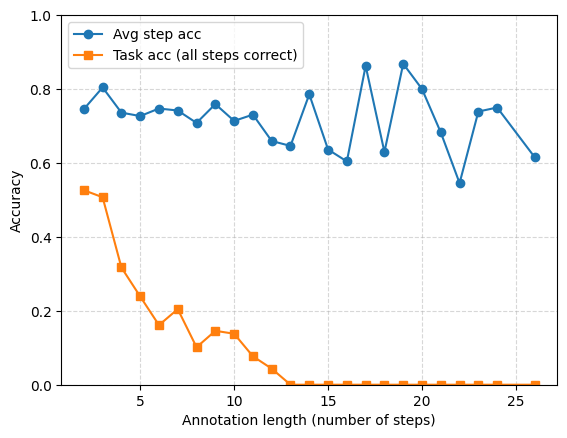

In [22]:
print("Evaluation on Test Set")
print(f"Avg task accuracy: {test_df['correct'].mean():.4f}")
print(f"Avg annotation accuracy: {test_task_group['correct'].min().mean():.4f}")
utils.plot.accuracy_vs_length(test_df);


In [23]:
targets = test_df[test_df['pred_set_size'] > 1]
example = targets.iloc[0]
example

relative_idx                                                     0
annotation_id                 91695df8-f256-47c9-8c37-06e8d0fc758f
action_uid                    73e0e7ed-d784-4b7a-a06c-48324e44ce7b
pred_label                                                       B
pred_action                                                  CLICK
pred_value                                                    None
label                                                            B
label_text                                       B.\nAction: CLICK
choices_probs    {'A': 0.15193545818328857, 'B': 0.846724271774...
prob                                                      0.846724
test_split                                                       0
labels_tokens                                  B.\nAction: CLICK\n
correct                                                       True
pred_set                                           [A, B, C, E, F]
pred_set_size                                                 

In [24]:
test_set = test_dict[idx_split_map[example['test_split']]]
html_context, seq_in, seq_out, prev_actions, choices_str = test_set.prompt_view[example['relative_idx']]

print(html_context)
print(seq_in)
print(f"output: {seq_out}")

# print(prev_actions)
# print(choices_str)

task = test_set.data[example['relative_idx']]['confirmed_task']
screenshot = test_set.data[example['relative_idx']]['screenshot']
print(task)

<html> <div> <a id=0 button> Reservations </a> <div> <li id=1> <a id=2> Trip Ideas </a> </li> <li id=3> <a id=4> Car Rental Las Vegas </a> </li> </div> </div> </html>
Based on the HTML webpage above, try to complete the following task:
Task: Rent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 on April 12 at 2:30 pm rented truck is to be returned to the exact location and date, and the pickup and drop off will be at the nearest location.
Previous actions:
What should be the next action? Please select from the following choices (If the correct action is not in the page above, please select A. 'None of the above'):

A. None of the above
B. <a id=0 button> Reservations </a>
C. <li id=1> <a id=2> Trip Ideas </a> </li>
D. <a id=2> Trip Ideas </a>
E. <li id=3> <a id=4> Car Rental Las Vegas </a> </li>
F. <a id=4> Car Rental Las Vegas </a>

output: B.
Action: CLICK

Rent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 

In [ ]:
mask = list(ord(label) - 65 for label in example['pred_set'])
choices_strs = choices_str.splitlines()
filtered_choices_str = '\n'.join(choices_strs[i] for i in mask)


'A. None of the above\nB. <a id=0 button> Reservations </a>\nC. <li id=1> <a id=2> Trip Ideas </a> </li>\nE. <li id=3> <a id=4> Car Rental Las Vegas </a> </li>\nF. <a id=4> Car Rental Las Vegas </a>'

In [30]:
# relative index 12
# annotation_id                 91695df8-f256-47c9-8c37-06e8d0fc758f
# action_uid                    f425232b-adc6-4047-b3ac-d56d8909b7df
prompt = f"""
{html_context}
Click the input field labeled "0" under the "Furniture Pad" add-on section to set the quantity to two dozen
the correct action is very likely one of the following. Analyze them carefully:

A. None of the above
B. <input id=0 text 0 />
C. <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li>
D. <li id=2> <a id=3 reservations> Reservations </a> </li>
E. <a id=3 reservations> Reservations </a>
F. <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a>
"""

prompt =f"""
Based on the HTML webpage above, try to complete the following task:
Task: Rent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 on April 12 at 2:30 pm rented truck is to be returned to the exact location and date, and the pickup and drop off will be at the nearest location.
Previous actions:
What should be the next action? Please select from the following choices (If the correct action is not in the page above, please select A. 'None of the above'):

{filtered_choices_str}
"""

model_input = tokenizer(prompt, return_tensors="pt",max_length=512).to(device)
with torch.inference_mode():
        out = model.generate(
        **model_input,
        max_new_tokens=15,
        return_dict_in_generate=True,
        output_scores=True
                    )
     
decoded = tokenizer.decode(out["sequences"][0], skip_special_tokens=True)
print(decoded)

B. Action: CLICK 


In [33]:
from torch.nn import functional as F
choices_to_token_ids = list(test_dict.values())[0].choices_token_ids_mapping()
choices_idx = torch.tensor(list(choices_to_token_ids.values()), device=device)
logits = out["scores"][0]
probs = F.softmax(logits, dim=-1)[:, choices_idx][0]
choices_probs = dict(zip(choices_to_token_ids.keys(), probs.cpu().tolist()))
print(choices_probs)

{'A': 0.40548041462898254, 'B': 0.5917925834655762, 'C': 0.00040538483881391585, 'D': 0.0009890374494716525, 'E': 0.00033939460990950465, 'F': 0.0006259293295443058}


In [34]:
print([1-p for p in choices_probs.values() if 1 - p <= threshold])

[0.5945195853710175, 0.40820741653442383, 0.9995946151611861, 0.9990109625505283, 0.9996606053900905, 0.9993740706704557]


In [ ]:
import gc
try:
    # Not enough memory for 2 models so we need to free GPU memory
    for d in set(model.hf_device_map.values()):
        if isinstance(d, int):
            torch.cuda.set_device(d)
            torch.cuda.empty_cache()
    del model
    gc.collect()         
    torch.cuda.empty_cache()       
    torch.cuda.ipc_collect()
except NameError:
    pass

try:
    # Not enough memory for 2 models so we need to free GPU memory
    for d in set(model.hf_device_map.values()):
        if isinstance(d, int):
            torch.cuda.set_device(d)
            torch.cuda.empty_cache()
    del oracle
    gc.collect()         
    torch.cuda.empty_cache()       
    torch.cuda.ipc_collect()
except NameError:
    pass

In [25]:
oracle = utils.llm.Oracle(cache_dir=CACHE_DIR)

/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [12]:
del oracle
gc.collect()         
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()

In [26]:
# del oracle
# gc.collect()         
# torch.cuda.empty_cache()       
# torch.cuda.ipc_collect()
answer=oracle.ask(task=task,
            prev_actions=prev_actions,
            html_context=html_context,
            choices=choices_str,
            candidates=example['pred_set'],
            image=screenshot)
print(answer)

OutOfMemoryError: CUDA out of memory. Tried to allocate 122.00 MiB. GPU 0 has a total capacity of 11.90 GiB of which 16.88 MiB is free. Process 2139090 has 8.22 GiB memory in use. Including non-PyTorch memory, this process has 3.65 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 349.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
"""
user

### ROLE
You are a helpful human annotator assisting a web navigation agent. The agent is confused and has narrowed down the next step to a few likely options, but it cannot distinguish which one is correct.
### USER TASK
Rent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 on April 12 at 2:30 pm rented truck is to be returned to the exact location and date, and the pickup and drop off will be at the nearest location.
Previous Actions: 
[button]  Reservations -> HOVER
[link]  Budget Truck -> CLICK
[textbox]  US City,State or Zip Code -> TYPE: 08817
[textbox]  mm/dd/yyyy -> CLICK
[link]  12 -> CLICK
[select]  Select Pick-up Time -> SELECT: 02:30 PM
[input]   -> CLICK
[button]  Find Your Truck -> CLICK
[button]  Select Truck -> CLICK
[input]   -> TYPE: 100
[button]  Continue to Location  -> CLICK
[button]  Select Pick-up Location -> CLICK


### HTML CONTEXT
<html> <div> <div> <a choose your add-ons /> <input id=0 text 0 /> <a choose your add-ons /> </div> <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li> <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a> </li> <a commercial account> Commercial Account </a> </ul> </div> </html>

### AVAILABLE OPTIONS
The smaller model has provided the following possible actions:
A. None of the above
B. <input id=0 text 0 />
C. <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li>
D. <li id=2> <a id=3 reservations> Reservations </a> </li>
E. <a id=3 reservations> Reservations </a>
F. <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a>


### THE AMBIGUOUS OPTIONS (Prediction Set)
The correct action is very likely one of the following. Analyze them carefully:
['A', 'B', 'D', 'F']

### INSTRUCTIONS
1. Analyze the User Task and the HTML Context (and the screenshot if available).
2. Identify the single correct element from the Prediction Set options above.
3. Formulate a natural language instruction to guide the agent to that specific element.
4. **Crucial:** Your instruction must be "Discriminative". Mention specific text labels, icons, or the location of the element to help the agent separate it from the other options.

### RESPONSE FORMAT
Provide your response as a direct command to the agent. 
- If the action is clicking, describe exactly what to click.
- If the action is typing, specify exactly what to type and where.

Example 1 (Click): "Click the 'Menu' button found in the top-left navigation bar."
Example 2 (Type): "Type 'The Matrix' into the search bar located in the header."
Example 3 (Select): "Select 'Price: Low to High' from the dropdown menu."

Your Response:  

assistant
Click the input field labeled "0" under the "Furniture Pad" add-on section to set the quantity to two dozen.
"""

In [22]:
del oracle
gc.collect()         
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()

CODE TO HANDLE:

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

from mind2web.dataloader import MultiChoiceDataset, get_data_split
from mind2web.evaluate import FastActionEvaluatorMultiChoice  # note the file name
# if installed as a package, you can also do: from mind2web.evauate import FastActionEvaluatorMultiChoice

# Load tokenizer/model
# model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")

# Prepare data (adjust paths/splits as needed)
# data_dir = "osunlp/Multimodal-Mind2Web"
# split_file = "test_task"  # example split
# data = get_data_split(data_dir, split_file)
# dataset = MultiChoiceDataset(data, tokenizer, num_candidates=5, max_context_len=512, mode="multichoice")

# Run evaluation
evaluator = FastActionEvaluatorMultiChoice(tokenizer, max_context_len=512)
result = evaluator.evaluate_dataset(
    test_dict["test_task"],  # dataset to evaluate
    model,
    batch_size=8,
    top_k=50,
    output_path='./results',  # set a folder path to save JSON outputs
    name="test_task",
    template=None,     # optionally a tuple (prefix_context, suffix_input)
    max_new_tokens=50,
)

print(result)


/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (125915272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import sys
import importlib

sys.path.append('./Mind2Web/src') 

# Force reload the metric module
if 'action_prediction.metric' in sys.modules:
    importlib.reload(sys.modules['action_prediction.metric'])

from action_prediction.metric import ActionEvaluatorGeneration, ActionEvaluatorMultiChoice

evaluator = ActionEvaluatorMultiChoice(tokenizer)
test_dataset = dataset
test_key = "task"
output_path = os.getcwd()
result = evaluator.evaluate_dataset(
    test_dataset,
    model,
    output_path=output_path,
    name=test_key,
    template=None, #lm_template,
    top_k=50#cfg.top_k,)
)


 12%|█▏        | 158/1339 [48:58<6:06:01, 18.60s/it, action_f1=0, element_acc=0]



KeyboardInterrupt: 

In [ ]:
# df = pd.DataFrame(test_task_ds)
# len(df.groupby("annotation_id"))
# subsample[0]['action_reprs']

# test_domain_ds = ds['test_domain']
# test_task_ds = ds['test_task']
# test_website_ds = ds['test_website']
count = 0
missing_count = 0
mulit = {}
missing = {}
for i, x in enumerate(test_task_ds):
    if len(x['pos_candidates']) > 1:
        count += 1
        mulit[i] = x['annotation_id']
    if len(x['pos_candidates']) == 0:
        # print('Missing pos_candidates:', x['annotation_id'])
        missing_count += 1
        missing[i] = x['annotation_id']

print("Number of samples with multiple positive candidates in test_website:", count)
print("Number of samples with missing positive candidates in test_website:", missing_count)

In [116]:
df[df['annotation_id'].str.startswith("15486e7c")]

,action_uid,raw_html,cleaned_html,operation,pos_candidates,neg_candidates,website,domain,subdomain,annotation_id,confirmed_task,screenshot,action_reprs,target_action_index,target_action_reprs,action_id


In [82]:
from bs4 import BeautifulSoup
html = task_df.iloc[0]["cleaned_html"]
soup = BeautifulSoup(html, "html.parser")

def get_element_html(node_id: str):
    el = soup.find(attrs={"backend_node_id": node_id})
    return str(el) if el is not None else None

# Example: show HTML for the top-1 candidate
best_id = task_df.iloc[0]["pos_candidates"][0]
print(get_element_html(best_id))

None


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Download the MindAct Candidate Generation model
print("Downloading MindAct Candidate Generation model...")
model_name = "osunlp/MindAct_CandidateGeneration_deberta-v3-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=CACHE_DIR)

# Load model
candidate_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    cache_dir=CACHE_DIR,
    torch_dtype=torch.float16,  # Use float16 for efficiency
    device_map="auto"  # Automatically handle device placement
)

print(f"Model {model_name} downloaded and loaded successfully!")
print(f"Model type: {type(candidate_model)}")
print(f"Number of parameters: {sum(p.numel() for p in candidate_model.parameters()):,}")